In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
from collections import Counter

In [4]:
class Config:
    TRAIN_PATH = '../inputs/train.csv'
    TEST_PATH = '../inputs/test.csv'
    TRAIN_LABELS = '../inputs/train_labels.csv'
    SAMPLE_SUBMISSION = '../inputs/sample_submission.csv'

In [5]:
train_df = pd.read_csv(Config.TRAIN_PATH)
train_labels = pd.read_csv(Config.TRAIN_LABELS)

In [6]:
train_labels['question'] = train_labels['session_id'].str.split('q').str[-1].astype('int8')
train_labels['session'] = train_labels['session_id'].str.split('_').str[0]
train_labels.head()

,session_id,correct,question,session
0,20090312431273200_q1,1,1,20090312431273200
1,20090312433251036_q1,0,1,20090312433251036
2,20090314121766812_q1,1,1,20090314121766812
3,20090314363702160_q1,1,1,20090314363702160
4,20090314441803444_q1,1,1,20090314441803444


In [7]:
train_labels['session'] = train_labels['session'].astype('int64')

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
CATS = ['event_name', 'fqid', 'room_fqid', 'text']
NUMS = ['elapsed_time','page','room_coor_x', 'room_coor_y',
        'screen_coor_x', 'screen_coor_y', 'hover_duration']
EVENTS = ['navigate_click','person_click','cutscene_click','object_click',
          'map_hover','notification_click','map_click','observation_click',
          'checkpoint']
ROOMS = ['historicalsociety',
          'kohlcenter',
          'capitol_0',
          'humanecology',
          'drycleaner',
          'library',
          'capitol_1',
          'wildlife',
          'flaghouse','capitol_2']

In [33]:
def groupby_apply_(g):
    res = {}
    diff = np.diff(g['elapsed_time'].values)
    res['elapsed_time_diff_mean'] = np.mean(diff)
    res['elapsed_time_diff_std'] = np.std(diff)
    res['elapsed_time_positive'] = len(diff[diff>0])
    res['elapsed_time_negative'] = len(diff) - res['elapsed_time_positive']
    res['start-end'] = g['elapsed_time'].values[-1] - g['elapsed_time'].values[0]
    for c1 in ROOMS:
        for c2 in EVENTS:
            res[f'{c1}_{c2}_sum'] = np.sum(g[f'{c1}_{c2}'])
    for c in NUMS+EVENTS +ROOMS+ ['elapsed_time']:
        res[f'{c}_sum'] = np.sum(g[c])
        res[f'{c}_mean'] = np.mean(g[c])
        res[f'{c}_std'] = np.mean(g[c])
        res[f'{c}_median'] = np.median(g[c])
    for c in CATS:
        res[f'{c}_nunique'] = len(set(g[c]))
    return pd.Series(res)
def feature_engineer(train):
    train['main_room'] = train['room_fqid'].str.split('.').str[1]
    x = pd.DataFrame()
    for c in EVENTS:
        x[c] = (train.event_name == c)
    for c in ROOMS:
        x[c] = (train.main_room == c)
    for c1 in ROOMS:
        for c2 in EVENTS:
            x[c1+'_'+c2] = (train['main_room'] == c1) & (train['event_name'] == c2)
    x = pd.concat([train,x],axis=1)
    df = x.groupby(['session_id','level_group']).apply(groupby_apply_)
    df = df.fillna(-999)
    df = df.reset_index()
    df = df.set_index('session_id')
    return df

In [34]:
train_df.columns

Index(['session_id', 'index', 'elapsed_time', 'event_name', 'name', 'level',
       'page', 'room_coor_x', 'room_coor_y', 'screen_coor_x',
       ...
       'flaghouse_checkpoint', 'capitol_2_navigate_click',
       'capitol_2_person_click', 'capitol_2_cutscene_click',
       'capitol_2_object_click', 'capitol_2_map_hover',
       'capitol_2_notification_click', 'capitol_2_map_click',
       'capitol_2_observation_click', 'capitol_2_checkpoint'],
      dtype='object', length=130)

In [35]:
%%time
df = feature_engineer(train_df)
print( df.shape )
df.head()

KeyboardInterrupt: 

In [23]:
from sklearn.model_selection import KFold, GroupKFold
from xgboost import XGBClassifier
from sklearn.metrics import f1_score

In [24]:
FEATURES = [c for c in df.columns if c not in [ 'level_group']]
print('We will train with', len(FEATURES) ,'features')
ALL_USERS = df.index.unique()
print('We will train with', len(ALL_USERS) ,'users info')

NameError: name 'df' is not defined

In [ ]:
n_splits=20
gkf = GroupKFold(n_splits=n_splits)
oof = pd.DataFrame(data=np.zeros((len(ALL_USERS),18)), index=ALL_USERS)
models = {}

# COMPUTE CV SCORE WITH 5 GROUP K FOLD
for i, (train_index, test_index) in enumerate(gkf.split(X=df, groups=df.index)):
    print('#'*25)
    print('### Fold',i+1)
    print('#'*25)

    xgb_params = {
        'objective' : 'binary:logistic',
        'eval_metric':'logloss',
        'learning_rate': 0.01,
        'max_depth': 5,
        'n_estimators': 2000,
        'early_stopping_rounds': 50,
        'tree_method':'hist',
        'subsample':0.8,
        'colsample_bytree': 0.8,
        'min_child_weight':2,
        'alpha':15,
        'lambda':42,
        'tree_method':'gpu_hist',
        'use_label_encoder' : False}

    # ITERATE THRU QUESTIONS 1 THRU 18
    for t in range(1,19):

        # USE THIS TRAIN DATA WITH THESE QUESTIONS
        if t<=3: grp = '0-4'
        elif t<=13: grp = '5-12'
        elif t<=22: grp = '13-22'

        # TRAIN DATA
        train_x = df.iloc[train_index]
        train_x = train_x.loc[train_x.level_group == grp]
        train_users = train_x.index.values
        train_y = train_labels.loc[train_labels.question==t].set_index('session').loc[train_users]

        # VALID DATA
        valid_x = df.iloc[test_index]
        valid_x = valid_x.loc[valid_x.level_group == grp]
        valid_users = valid_x.index.values
        valid_y = train_labels.loc[train_labels.question==t].set_index('session').loc[valid_users]

        # TRAIN MODEL
        clf =  XGBClassifier(**xgb_params)
        clf.fit(train_x[FEATURES].astype('float32'), train_y['correct'],
                eval_set=[(train_x[FEATURES].astype('float32'), train_y['correct']), (valid_x[FEATURES].astype('float32'), valid_y['correct']) ],
                verbose=100)
        print(f'{t}({clf.best_ntree_limit}), ',end='')

        # SAVE MODEL, PREDICT VALID OOF
        models[f'{i}_{grp}_{t}'] = clf
        oof.loc[valid_users, t-1] = clf.predict_proba(valid_x[FEATURES].astype('float32'))[:,1]

    print()



In [ ]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_df = fi_df.head(70)
    #Define size of bar plot
    plt.figure(figsize=(20,10))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

In [ ]:
feat_imp = {}

In [ ]:
for k, v in models.items():
    for x, y in zip(v.feature_importances_, v.feature_names_in_):
        if y not in feat_imp:
            feat_imp[y] = x
        else:
            feat_imp[y]+=x

In [ ]:
plot_feature_importance(list(feat_imp.values()),list(feat_imp.keys()),'')

In [ ]:
feat = pd.DataFrame({'score':list(feat_imp.values()),'feats':list(feat_imp.keys())})

In [ ]:
feat.sort_values('score',ascending=False)['feats'].values[:100]

In [ ]:
# PUT TRUE LABELS INTO DATAFRAME WITH 18 COLUMNS
true = oof.copy()
for k in range(18):
    # GET TRUE LABELS
    tmp = train_labels.loc[train_labels.question == k+1].set_index('session').loc[ALL_USERS]
    true[k] = tmp.correct.values

In [ ]:
# FIND BEST THRESHOLD TO CONVERT PROBS INTO 1s AND 0s
scores = []; thresholds = []
best_score = 0; best_threshold = 0

for threshold in np.arange(0.4,0.81,0.01):
    print(f'{threshold:.02f}, ',end='')
    preds = (oof.values.reshape((-1))>threshold).astype('int')
    m = f1_score(true.values.reshape((-1)), preds, average='macro')
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score:
        best_score = m
        best_threshold = threshold

In [ ]:
import matplotlib.pyplot as plt

# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold], [best_score], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score:.4f} at Best Threshold = {best_threshold:.3}',size=18)
plt.show()

In [ ]:
print('When using optimal threshold...')
for k in range(18):
        
    # COMPUTE F1 SCORE PER QUESTION
    m = f1_score(true[k].values, (oof[k].values>best_threshold).astype('int'), average='macro')
    print(f'Q{k}: F1 =',m)
    
# COMPUTE F1 SCORE OVERALL
m = f1_score(true.values.reshape((-1)), (oof.values.reshape((-1))>best_threshold).astype('int'), average='macro')
print('==> Overall F1 =',m)

In [318]:
train_df['room_fqid'].unique()

array(['tunic.historicalsociety.closet',
       'tunic.historicalsociety.basement',
       'tunic.historicalsociety.entry',
       'tunic.historicalsociety.collection',
       'tunic.historicalsociety.stacks', 'tunic.kohlcenter.halloffame',
       'tunic.capitol_0.hall', 'tunic.historicalsociety.closet_dirty',
       'tunic.historicalsociety.frontdesk',
       'tunic.humanecology.frontdesk', 'tunic.drycleaner.frontdesk',
       'tunic.library.frontdesk', 'tunic.library.microfiche',
       'tunic.capitol_1.hall', 'tunic.historicalsociety.cage',
       'tunic.historicalsociety.collection_flag', 'tunic.wildlife.center',
       'tunic.flaghouse.entry', 'tunic.capitol_2.hall'], dtype=object)

In [214]:
import seaborn as sns

<AxesSubplot:xlabel='screen_coor_x', ylabel='screen_coor_y'>

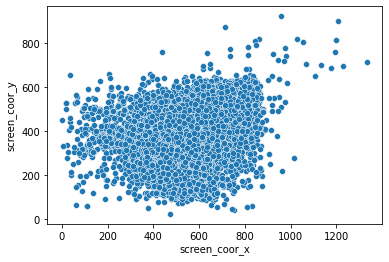

In [240]:
sns.scatterplot(x='screen_coor_x', y='screen_coor_y', data=train_df[(train_df.room_fqid=='tunic.historicalsociety.closet')&(train_df['index']==1)]) 

In [231]:
train_df.groupby('session_id').tail(2)

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,...,flaghouse_checkpoint,capitol_2_navigate_click,capitol_2_person_click,capitol_2_cutscene_click,capitol_2_object_click,capitol_2_map_hover,capitol_2_notification_click,capitol_2_map_click,capitol_2_observation_click,capitol_2_checkpoint
879,20090312431273200,930,1270708,navigate_click,undefined,22,NaN,224.190321,-60.268671,404.0,...,False,True,False,False,False,False,False,False,False,False
880,20090312431273200,931,1272679,checkpoint,basic,22,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,True
2710,20090312433251036,1874,3813349,navigate_click,undefined,22,NaN,239.341836,-17.844428,414.0,...,False,True,False,False,False,False,False,False,False,False
2711,20090312433251036,1875,3815334,checkpoint,basic,22,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,True
3748,20090314121766812,1081,2133005,navigate_click,undefined,22,NaN,270.625777,0.376447,498.0,...,False,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13171795,22100217104993650,1248,2103885,checkpoint,basic,22,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,True
13172662,22100219442786200,919,1216907,navigate_click,undefined,22,NaN,266.614564,9.428299,432.0,...,False,True,False,False,False,False,False,False,False,False
13172663,22100219442786200,920,1218877,checkpoint,basic,22,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,True
13174209,22100221145014656,1603,5486753,navigate_click,undefined,22,NaN,252.299653,123.805889,526.0,...,False,True,False,False,False,False,False,False,False,False


In [234]:
trai

0        11769
11       11769
1        11769
25       11769
24       11769
         ...  
10437        1
10438        1
10439        1
10440        1
20473        1
Name: index, Length: 20348, dtype: int64

In [319]:
import pickle

In [324]:
with open('student-performance-2502.pkl','wb') as file:
    pickle.dump(models,file)